# Seurat 3.0 "Guided tutorial"
元URL: https://satijalab.org/seurat/v3.0/pbmc3k_tutorial.html

以下のコマンドはR上で実行します。

In [2]:
# ライブラリ読み込み
library(dplyr)
library(Seurat)

## バージョンの確認
sessionInfoコマンドを使って今読み込んでいるライブラリのバージョンを確認します。エラーの多くは古いバージョンなどを使っていることに起因しますので、常にバージョンを確認する癖をつけておきましょう。下の例では R version 3.6.1, Seuratのバージョンは3.1.0 です。

In [5]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] Seurat_3.1.0 dplyr_0.8.3 

loaded via a namespace (and not attached):
 [1] nlme_3.1-141        tsne_0.1-3          bitops_1.0-6       
 [4] RcppAnnoy_0.0.13    RColorBrewer_1.1-2  httr_1.4.1         
 [7] repr_1.0.1          sctransform_0.2.0   tools_3.6.1        
[10] R6_2.4.0            irlba_2.3.3         KernSmooth_

## データ読み込み
PBMCのデータ2700細胞を読み込みます。ここでは10Xで生成されたデータをそのまま読み込めるRead10Xコマンドを利用しています。
入力データとして、filtered_gene_bc_matrices 内の hg19 フォルダを指定します。

生成されたSeuratオブジェクトを確認すると、2700細胞 × 13714遺伝子の行列データになっていることがわかります。

In [19]:
# Load the PBMC dataset (cellrangerのraw dataを読み込み、UMIの行列に変換)
pbmc.data <- Read10X(data.dir = "./filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
# min.cells, min.features はそれぞれ最低発現細胞数、遺伝子数
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features)

カウント行列の中身を閲覧するには、pbmc[["RNA"]]@counts または pbmc.data と指定します。
この２つはいずれもUMI値ですが遺伝子の並び順は異なるようです。

UMI値を表示した時のドットは発現量が0であることを表します。sparse-matrix representationによってメモリ使用量を抑えています。

In [20]:
# 最初の20細胞中の冒頭10遺伝子についてUMI値を表示
pbmc[["RNA"]]@counts[1:10,1:20]
# pbmc.data[1:10,1:20]  でも同じ（並び順は異なる）

   [[ suppressing 20 column names ‘AAACATACAACCAC’, ‘AAACATTGAGCTAC’, ‘AAACATTGATCAGC’ ... ]]


10 x 20 sparse Matrix of class "dgCMatrix"
                                                     
AL627309.1    . . . . . . . . . . . . . . . . . . . .
AP006222.2    . . . . . . . . . . . . . . . . . . . .
RP11-206L10.2 . . . . . . . . . . . . . . . . . . . .
RP11-206L10.9 . . . . . . . . . . . . . . . . . . . .
LINC00115     . . . . . . . . . . . . . . . . . . . .
NOC2L         . . . . . . . . . . . 1 . . . . . . . .
KLHL17        . . . . . . . . . . . . . . . . . . . .
PLEKHN1       . . . . . . . . . . . . . . . . . . . .
RP11-54O7.17  . . . . . . . . . . . . . . . . . . . .
HES4          . . . . . . . . . . . . . . . . . . 1 .

In [21]:
# 最初の30細胞における特定の遺伝子を表示
pbmc.data["CD3D", 1:30]  # 1遺伝子の場合
pbmc.data[c("CD3D", "TCL1A", "MS4A1"), 1:30]  # 複数遺伝子を指定する場合

AAACATACAACCAC AAACATTGAGCTAC AAACATTGATCAGC AAACCGTGCTTCCG AAACCGTGTATGCG 
             4              0             10              0              0 
AAACGCACTGGTAC AAACGCTGACCAGT AAACGCTGGTTCTT AAACGCTGTAGCCA AAACGCTGTTTCTG 
             1              2              3              1              0 
AAACTTGAAAAACG AAACTTGATCCAGA AAAGAGACGAGATA AAAGAGACGCGAGA AAAGAGACGGACTT 
             0              2              7              1              0 
AAAGAGACGGCATT AAAGATCTGGGCAA AAAGCAGAAGCCAT AAAGCAGATATCGG AAAGCCTGTATGCG 
             0              1              3              0              2 
AAAGGCCTGTCTAG AAAGTTTGATCACG AAAGTTTGGGGTGA AAAGTTTGTAGAGA AAAGTTTGTAGCGT 
             3              0              0              0              0 
AAATCAACAATGCC AAATCAACACCAGT AAATCAACCAGGAG AAATCAACCCTATT AAATCAACGGAAGC 
             0              3              4              1              5

   [[ suppressing 30 column names ‘AAACATACAACCAC’, ‘AAACATTGAGCTAC’, ‘AAACATTGATCAGC’ ... ]]


3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

## 品質評価（QC）

Seuratでは品質評価指標として全UMIにおけるミトコンドリアRNAの割合(%)を用います。
以下ではその値を "percent.mt" という列名でpbmcオブジェクトに新たに追加します。

(ここでは遺伝子名が"MT-"で始まる遺伝子をミトコンドリアRNAとみなしています。)

In [22]:
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

QCの値はpbmc@meta.dataに格納されます。
"percent.mt"の他、nCount: 総UMI数, nFeature: 発現遺伝子数　の値が格納されています。

In [23]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG,pbmc3k,980,521,1.2244898


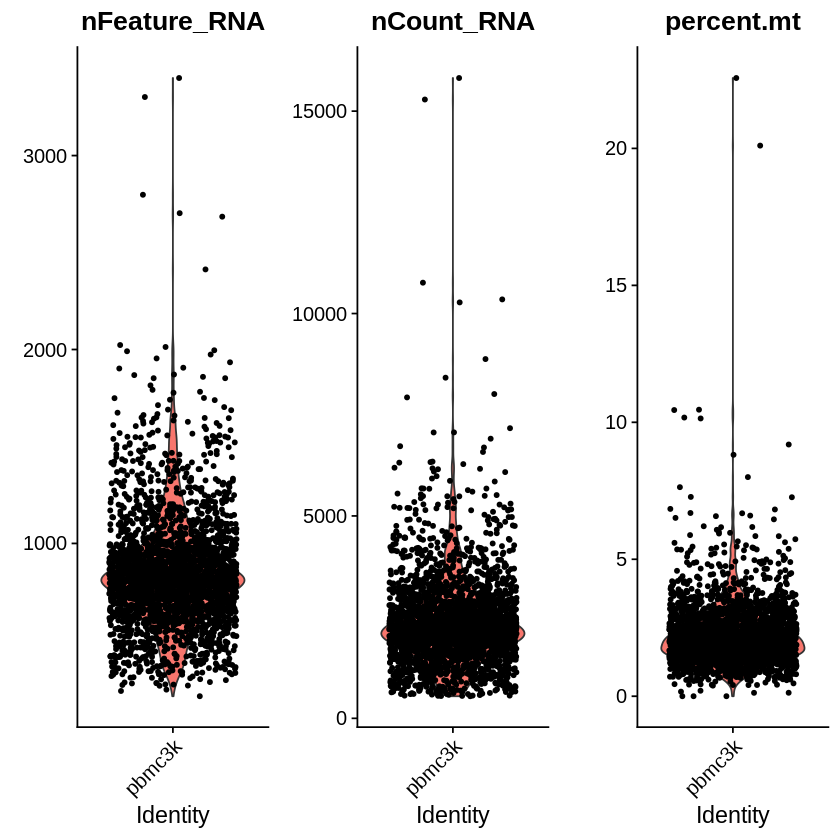

In [24]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

以下では二種類のQC値を散布図としてプロットしています。
これにより、「UMI値に対して発現遺伝子数が少なすぎる」というような細胞を検出することができます。

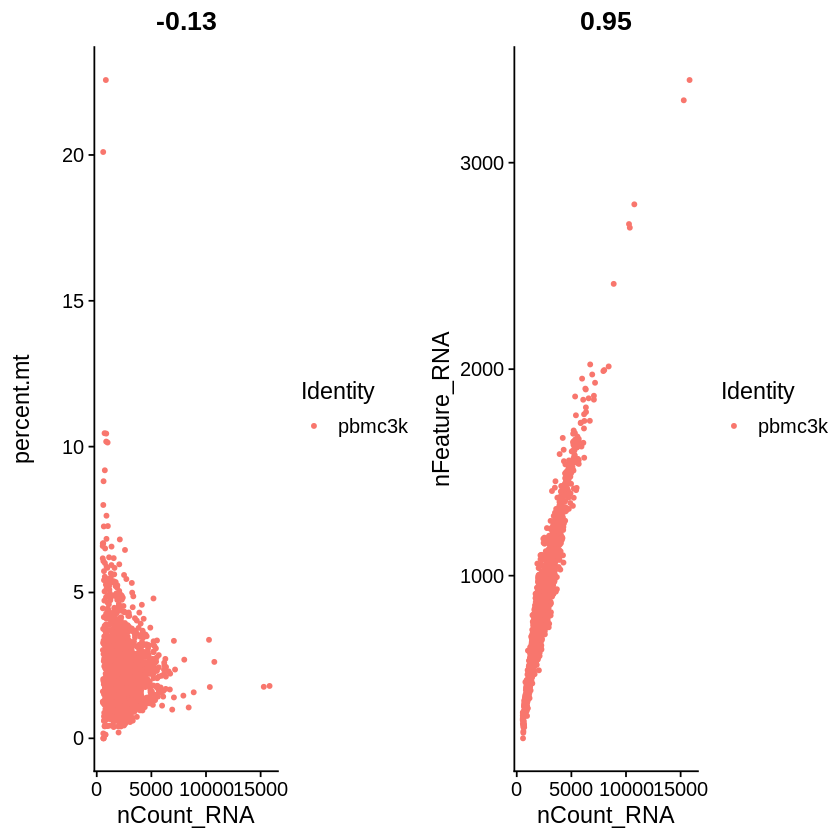

In [25]:
# CombinePlots関数で２つの図を同時に表示
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
CombinePlots(plots = list(plot1, plot2))

以下のコマンドでは実際におかしな値を持つ細胞をフィルタしています。

**subset**　コマンドは、**=** 以後の条件を満たす細胞だけを返します。
'条件1 & 条件2' は「条件１かつ条件２」を示します。

In [26]:
### We filter cells that have unique feature counts over 2,500 or less than 200
### and cells that have >5% mitochondrial counts
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

## 正規化
細胞ごとの総UMI数が10,000になるように正規化します。
また、**normalization.method = "LogNormalize"** を指定すると正規化後対数変換されます。

（注：scRNA-seqのためのツールでは、**正規化後の行列**を要求するものと**正規化前の行列**を要求するものがありますので、自分が今どのデータを使っているかは常に意識しておく必要があります。Seuratは対数変換された正規化行列を以降の解析で用います。）

In [27]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

### Highly variable genes の抽出

クラスタリング解析においては、細胞間で「発現量に対して細胞ごとの変動（分散）が大きい遺伝子 (**Highly variable genes**)」 が基本的な興味の対象となります。
そこでここでは、特に分散の大きい 2,000遺伝子のみを抽出して残りは削除するという操作を行います。

これは前述のQCとは異なり、主に計算量を削減するための操作です。従ってマシンパワーが許すならこの操作を行わなくても構いません（その方が望ましいと思います）。

When using repel, set xnudge and ynudge to 0 for optimal results
Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”

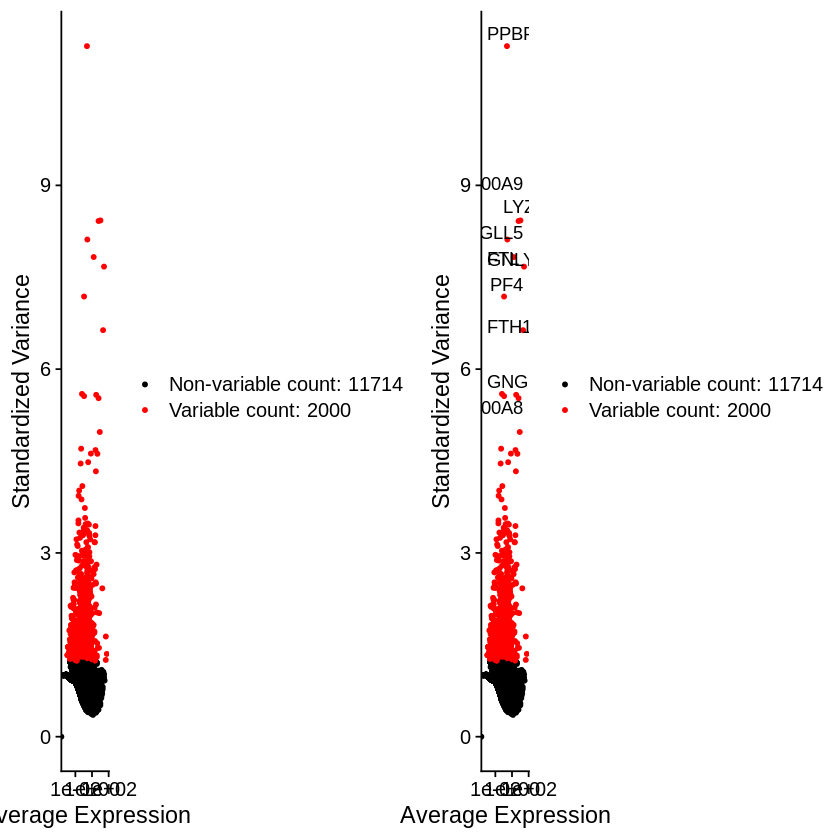

In [28]:
### Seurat3 directly models the mean-variance relationship inherent in single-cell data,
### By default, we return 2,000 features per dataset.
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# 上位10個のHVGをtop10に格納
top10 <- head(VariableFeatures(pbmc), 10)

# HVGを赤色として「発現量ー分散」の散布図をプロット
plot1 <- VariableFeaturePlot(pbmc)  # top10ラベルなし
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)  # top10ラベルあり
CombinePlots(plots = list(plot1, plot2))

### Scaling
以下では対数化された正規化後UMI数を更に、各遺伝子について、全細胞に対し、
発現量の平均が0、分散が1になるようにスケーリングします（Zスコア的？）

In [29]:
all.genes <- rownames(pbmc)
#pbmc <- ScaleData(pbmc, features = all.genes)  # scaled by all genes
pbmc <- ScaleData(pbmc)   # scaled by highly variable (2,000) genes
### The results of this are stored in pbmc[["RNA"]]@scale.data

Centering and scaling data matrix


## 次元削減
細胞を2次元上でプロットするため、遺伝子数の要素（次元）を持つ各細胞を2次元に**次元削減**します。
簡単に言えば、３次元の風景の写真を撮ると、2次元の画像に次元削減されるということと考え方は同じです。
PCA（主成分分析）においては、３次元の風景の要素を可能な限り残したまま２次元にする、という作業が、適切な主成分（PC1, PC2）を選択していることになります。

以下では**PCA, tSNE, UMAP**の三種類の次元削減法を試します。

### PCA

In [33]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

#### Examine and visualize PCA results a few different ways

In [34]:
# PC1からPC5までの上位・下位トップランク遺伝子を表示
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, NKG7, S100A8, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


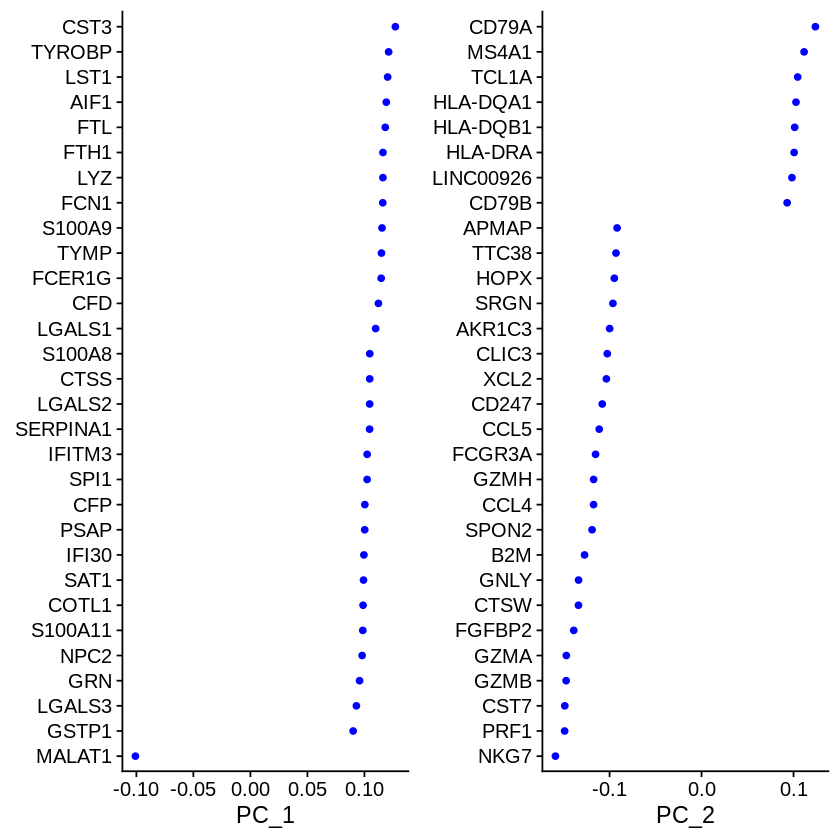

In [35]:
# PC1, PC2について同様に図で表示
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

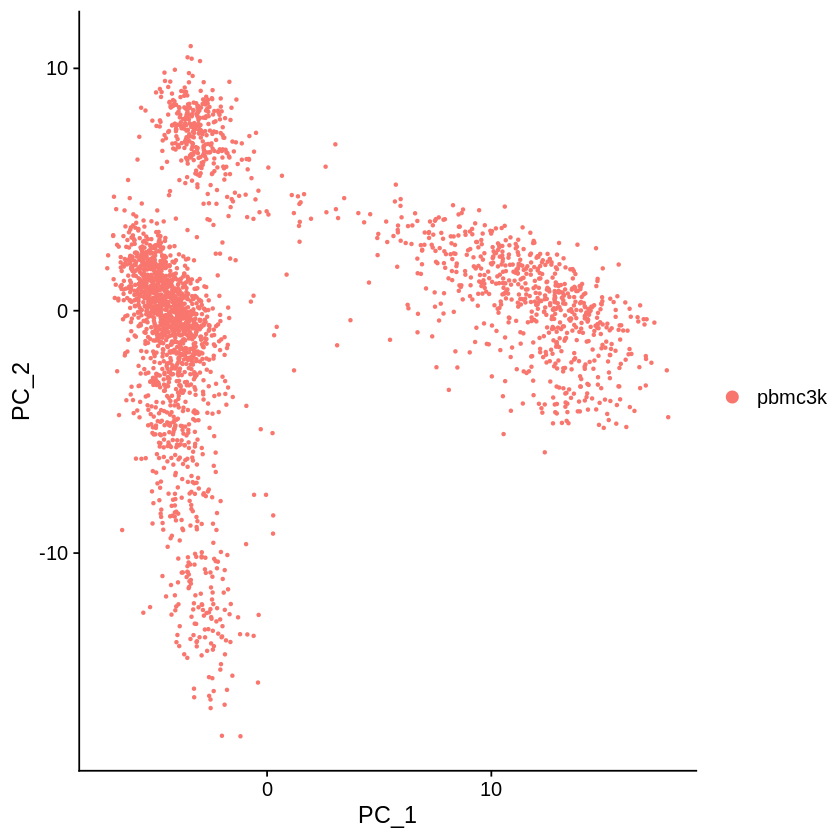

In [36]:
# PC1, PC2の散布図表示
DimPlot(pbmc, reduction = "pca")

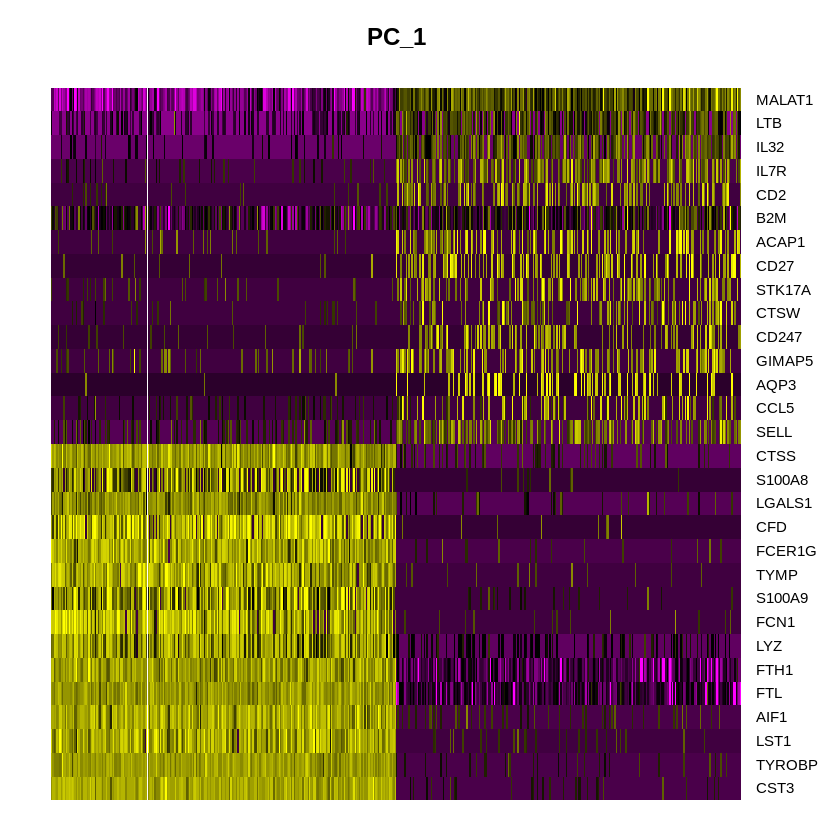

In [38]:
# PC1方向で正負トップランクの遺伝子について、ランダムに選ばれたそれぞれ500細胞での値を可視化
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

### 意味のある次元数の推定
SeuratではtSNE, UMAPを用いて次元削減する場合、発現量を直接使うのではなく、PCAで得られた主成分を使って更にtSNE, UMAPを実行します。
その時、「第何主成分まで使えば元データの情報量を失わずに解析できるか」を確かめるため、いくつかの方法を用います。

（実際にはデフォルトの第10主成分まででよいことが多く、特に気にならなければこれらの工程はスキップしても問題ありません。）

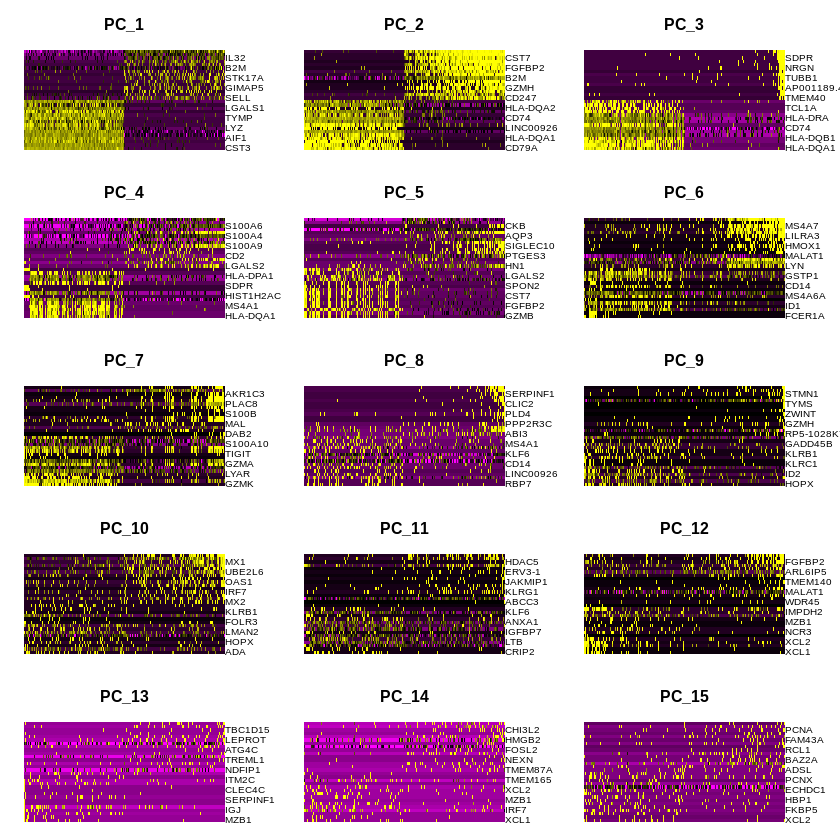

In [40]:
# PC15までを一度に可視化 (目で見る主観的な方法だが有用性が高い)
#（２分されているように見えなければ、その主成分にはもう情報がないと言える）
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

Warning message:
“Removed 23501 rows containing missing values (geom_point).”

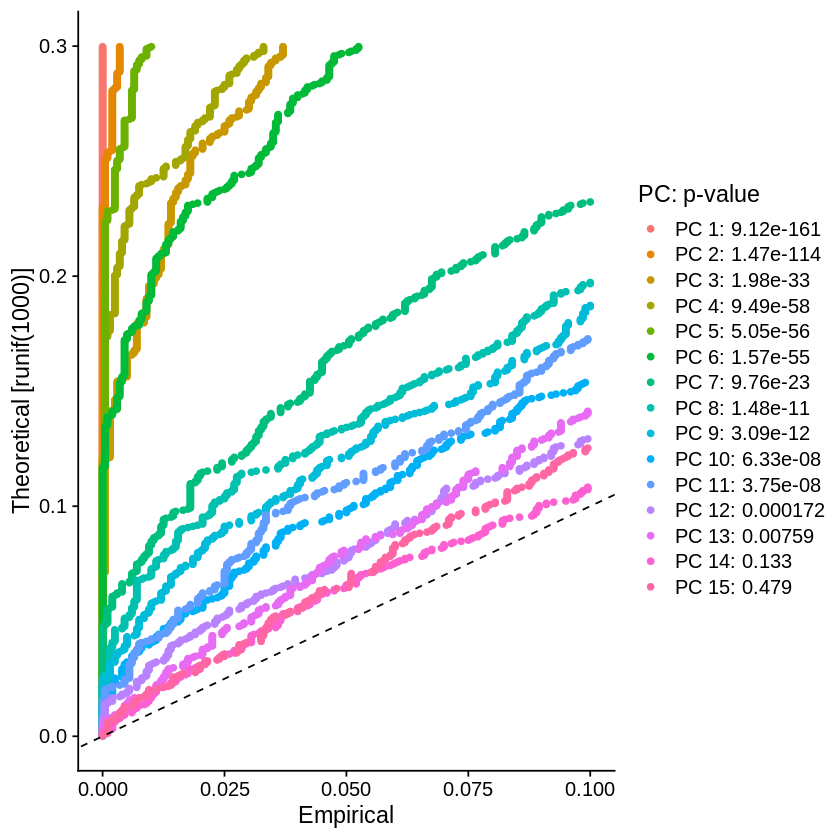

In [54]:
# Jack-Straw plotによる主成分の可視化
# 黒点線で示されたランダム状態より上に振れているほど情報量が多い
# 実際には主観的であるうえに計算量が非常に多いので個人的にはスキップ推奨
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)
JackStrawPlot(pbmc, dims = 1:15)

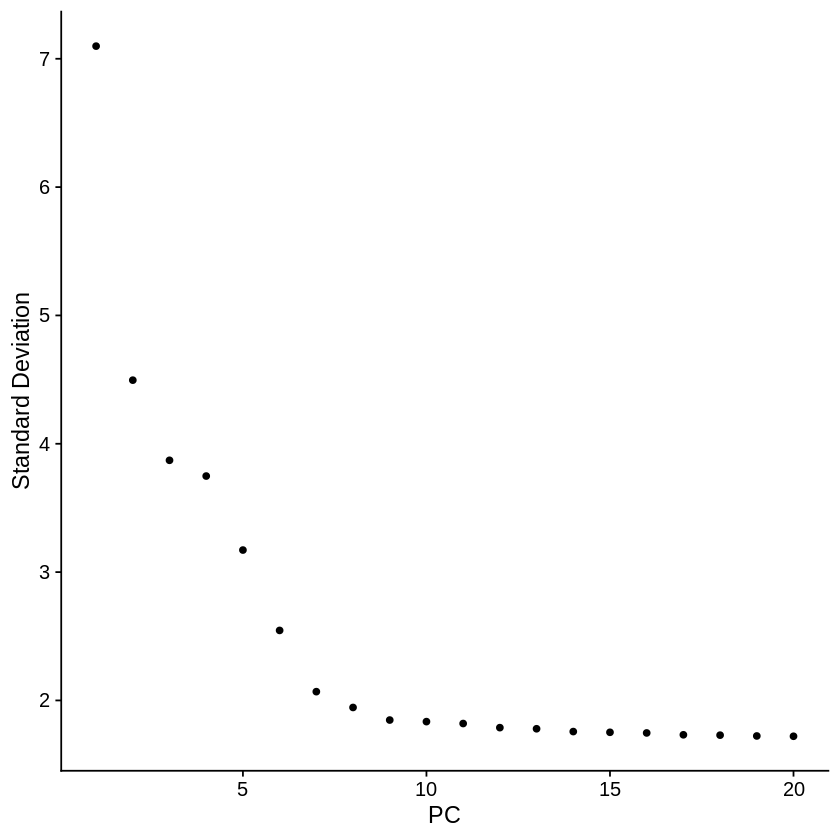

In [41]:
# Elbow plotによる可視化
# 横軸が主成分の次元を表し、降下曲線から水平になる点（Elbow）が最適な主成分の次元数
ElbowPlot(pbmc)

In [57]:
# This step is performed using the FindNeighbors function, and takes as input the previously defined dimensionality of the dataset (first 10 PCs).

# 第10主成分までの値を元にKNNグラフ作成
pbmc <- FindNeighbors(pbmc, dims = 1:10)
# グラフを元にクラスタリング (resolutionを変えるとクラスタ数が変わる)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95937

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


## Clustering
Seurat v3は **graph-based clustering approach** (PhenoGraph)を用いてクラスタリングします。
これは細胞群をグラフ構造とし、例えばK最近傍（KNN）グラフに埋め込んで、類似の特徴パターンを持つ細胞間に辺（エッジ）を描き、相互に高度に連結した部分細胞群（「準クリーク」または 「コミュニティ」）をクラスタとして抽出する方法です。

SeuratはPhenoGraphの場合と同様に、まずPCA空間でのユークリッド距離に基づいてK最近傍グラフを作成し、任意の2細胞について、2細胞間の全エッジの重なり（Jaccard類似度）に基づいて２細胞間のエッジの重みを調整します。従って、クラスタリング結果はtSNE, UMAPどちらを使うかには依存しません。

グラフクラスタリングではクラスタ数を直接指定することはできず、**FindClusters** コマンドで resolution を指定することでクラスタ数が変化します。得られたクラスタ数は "Number of communities" に表示されます。

In [50]:
# 第10主成分までの値を元にKNNグラフ作成
pbmc <- FindNeighbors(pbmc, dims = 1:10)
# グラフを元にクラスタリング
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95937

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


In [51]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACATACAACCAC AAACATTGAGCTAC AAACATTGATCAGC AAACCGTGCTTCCG AAACCGTGTATGCG 
             0              3              2              1              6 
Levels: 0 1 2 3 4 5 6 7 8

### tSNE

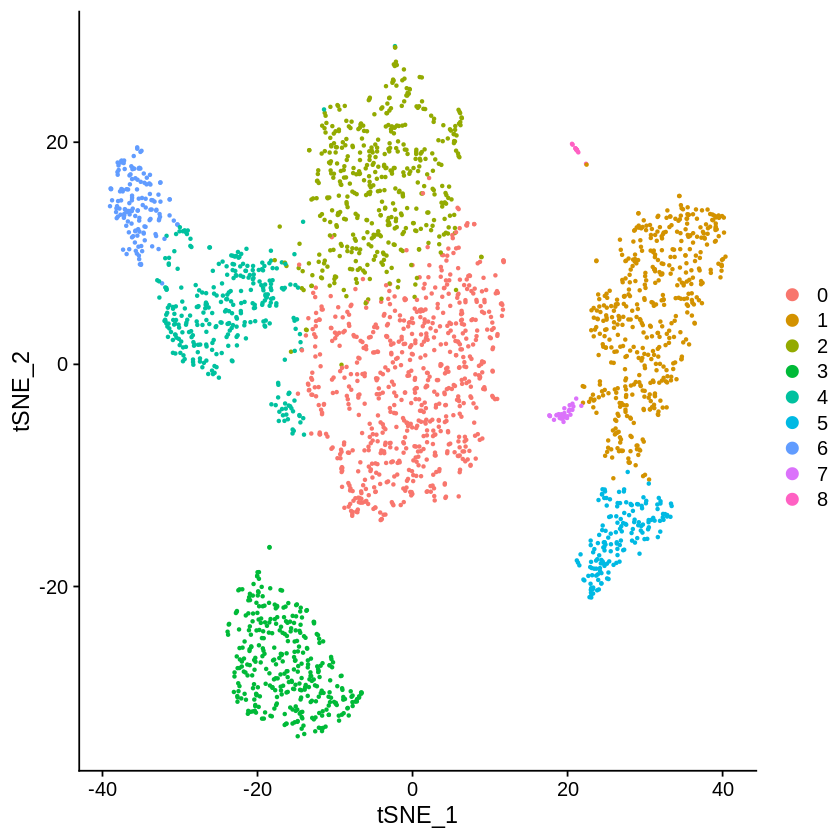

In [44]:
pbmc <- RunTSNE(pbmc, dims = 1:10)
DimPlot(pbmc, reduction = "tsne")

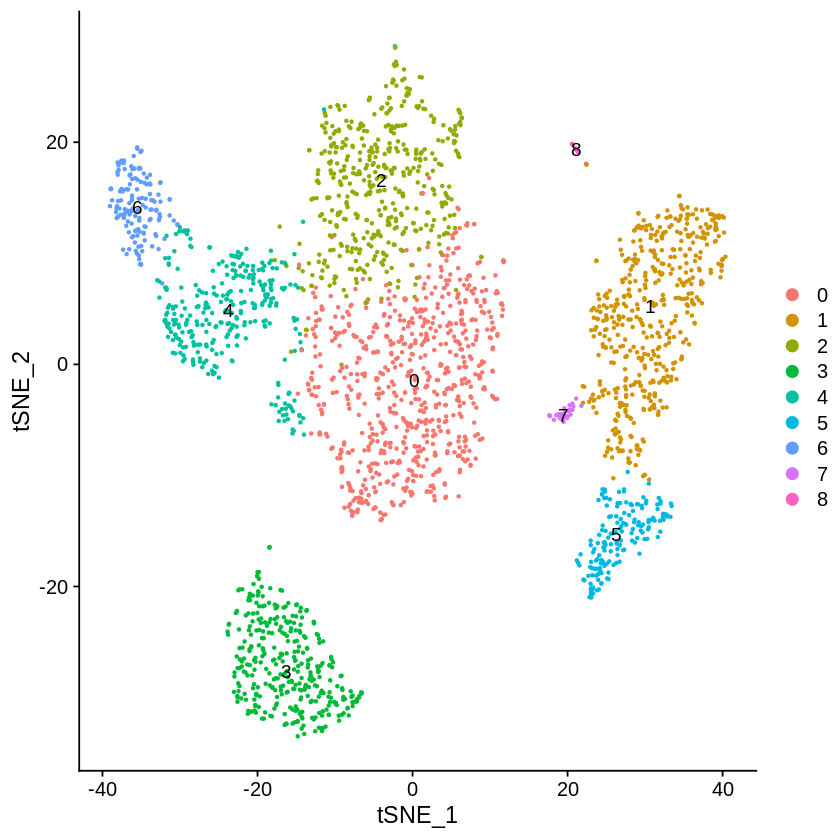

In [60]:
# "label = TRUE" をつけると細胞ラベルありになる
DimPlot(pbmc, reduction = "tsne", label = TRUE)

### UMAP

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”05:19:27 UMAP embedding parameters a = 0.9922 b = 1.112
05:19:27 Read 2638 rows and found 10 numeric columns
05:19:27 Using Annoy for neighbor search, n_neighbors = 30
05:19:27 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
05:19:27 Writing NN index file to temp file /tmp/RtmpPZaZNK/filecc34be86a0
05:19:27 Searching Annoy index using 1 thread, search_k = 3000
05:19:28 Annoy recall = 100%
05:19:28 Commencing smooth kNN distance calibration using 1 thread
05:19:29 Initializing from normalized Laplacian + noise
05:19:29 Commencing optimization 

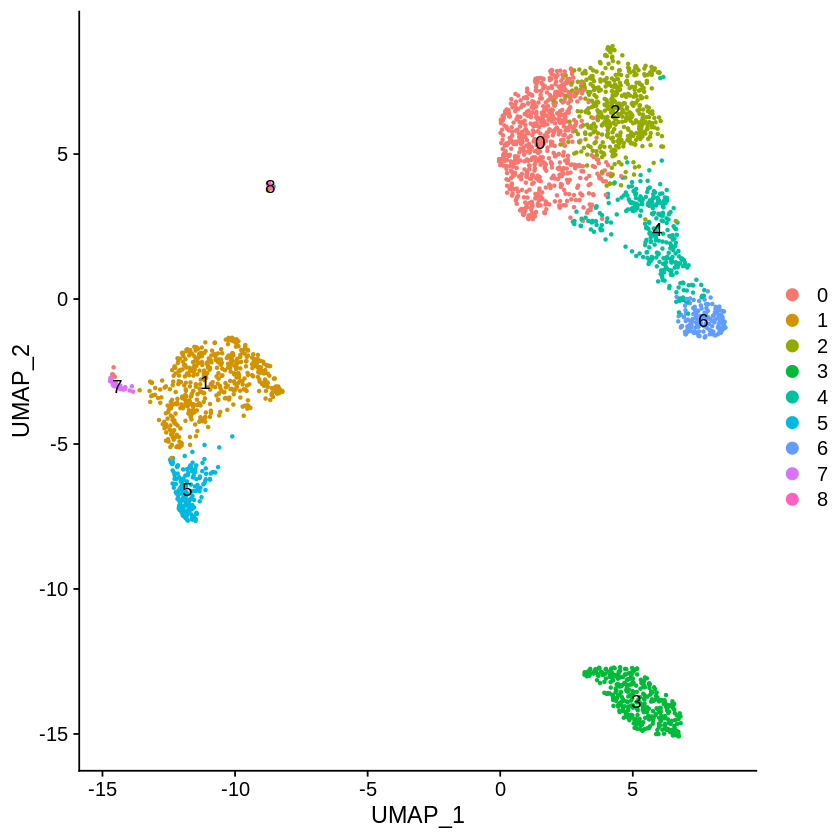

In [45]:
pbmc <- RunUMAP(pbmc, dims = 1:10)
DimPlot(pbmc, reduction = "umap", label = TRUE)

### データ保存
ここまでの作業を毎回繰り返さなくてもよいように、pbmcオブジェクトをファイルとして出力することができます。

In [62]:
# データ保存
saveRDS(pbmc, file = "pbmc_tutorial.rds")
# 保存したデータを後から読み込む場合
# pbmc <- readRDS("pbmc_tutorial.rds")

### Sleepwalkを用いた細胞間発現類似度の可視化
PCAは線形変換のため高次元上での距離がある程度保存されますが、tSNE, UMAPは非線形変換であるため、高次元での相対的な距離やばらつきが保存されません。それを確認するために、Sleepwalkというツールを用いて類似度を可視化したいと思います。

元URL: https://anders-biostat.github.io/sleepwalk/

In [47]:
# ライブラリ読み込み
library(sleepwalk)

In [48]:
# 以下のコマンドを実行し、生成された"sleepwalk.html"をブラウザで開いてください。
sleepwalk(list(pbmc@reductions$pca@cell.embeddings[,1:2],
               pbmc@reductions$tsne@cell.embeddings,
               pbmc@reductions$umap@cell.embeddings),
          pbmc@reductions$pca@cell.embeddings,
          saveToFile="sleepwalk.html")

Estimating 'maxdist' for feature matrix 1


### クラスタごとのマーカ遺伝子抽出 （発現変動解析）
得られたクラスタごとに特徴的に発現している遺伝子を同定します。原理的には特異的に発現が失われている遺伝子も含みますが、実際には高発現遺伝子のみが対象にされることが多いです。

クラスタは通常３つ以上生成されますが、Seuratでは特定のクラスタと、それ以外の全てのクラスタの２群間比較を行います。その結果、２つのクラスタにまたがって高発現している遺伝子などは、抽出されにくくなっていると思われます。

In [69]:
# クラスタ1に特異的な遺伝子の抽出
# min.pct: 2群のいずれかで、この割合以上の細胞数が発現している遺伝子のみを対象とする
cluster1.markers <- FindMarkers(pbmc, ident.1 = 1, min.pct = 0.25)
head(cluster1.markers, n = 5)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A9,0.000000e+00,3.860873,0.996,0.215,0.000000e+00
S100A8,0.000000e+00,3.796640,0.975,0.121,0.000000e+00
LGALS2,0.000000e+00,2.634294,0.908,0.059,0.000000e+00
FCN1,0.000000e+00,2.352693,0.952,0.151,0.000000e+00
CD14,2.856582e-294,1.951644,0.667,0.028,3.917516e-290


In [ ]:
# 利用できる発現変動解析法は複数ある。詳細：https://satijalab.org/seurat/v3.0/de_vignette.html
# cluster1.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

In [70]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,4.742054e-206,2.949309,0.975,0.041,6.503252e-202
CFD,1.290357e-197,2.372577,0.938,0.036,1.769595e-193
IFITM3,1.513812e-197,2.687676,0.975,0.049,2.076042e-193
CD68,3.196742e-194,2.096339,0.926,0.034,4.384012e-190
RP11-290F20.3,2.790597e-189,1.886624,0.840,0.016,3.827024e-185


**FindAllMarkers** コマンドを使うと、全クラスタから一度に変動遺伝子を抽出できます。
"only.pos = TRUE" オプションをつけることで、高発現遺伝子のみが出力されます。

In [52]:
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8


p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
7.468943e-120,0.7698980,0.917,0.587,1.024291e-115,0,LDHB
2.808551e-87,0.9323437,0.443,0.107,3.851647e-83,0,CCR7
0.000000e+00,3.8608733,0.996,0.215,0.000000e+00,1,S100A9
0.000000e+00,3.7966403,0.975,0.121,0.000000e+00,1,S100A8
4.812603e-82,0.8695514,0.982,0.646,6.600003e-78,2,LTB
8.953443e-56,0.8559793,0.423,0.114,1.227875e-51,2,AQP3
0.000000e+00,2.9875833,0.936,0.041,0.000000e+00,3,CD79A
9.481783e-271,2.4894932,0.622,0.022,1.300332e-266,3,TCL1A
1.647227e-199,2.1375668,0.958,0.232,2.259008e-195,4,CCL5


### 指定した遺伝子をクラスタごとに分けてviolin plot

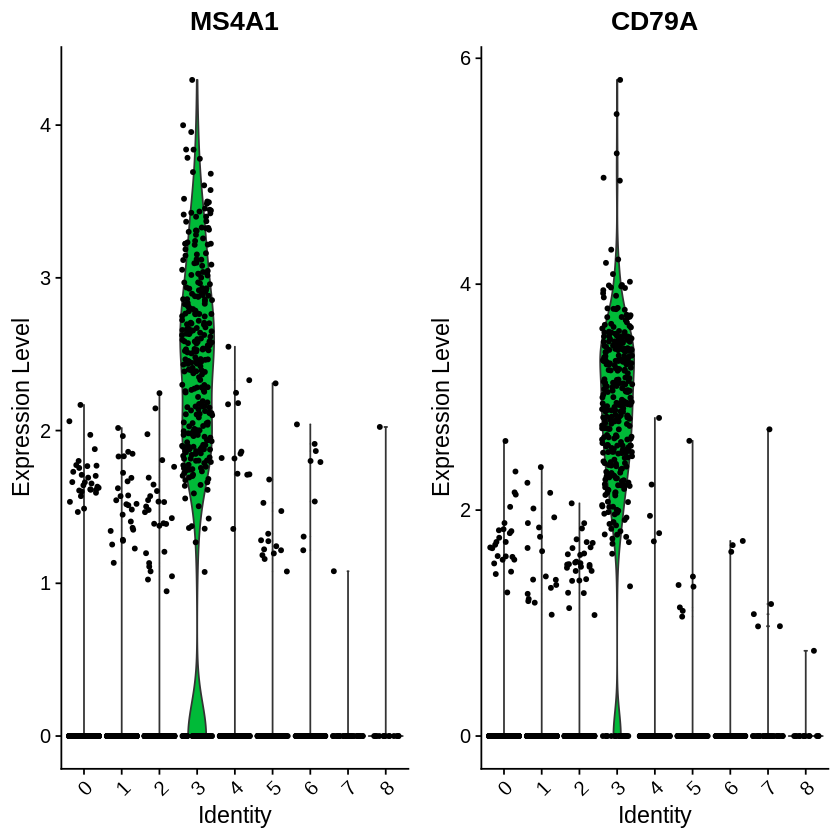

In [30]:
# violin plot (正規化後発現量)
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

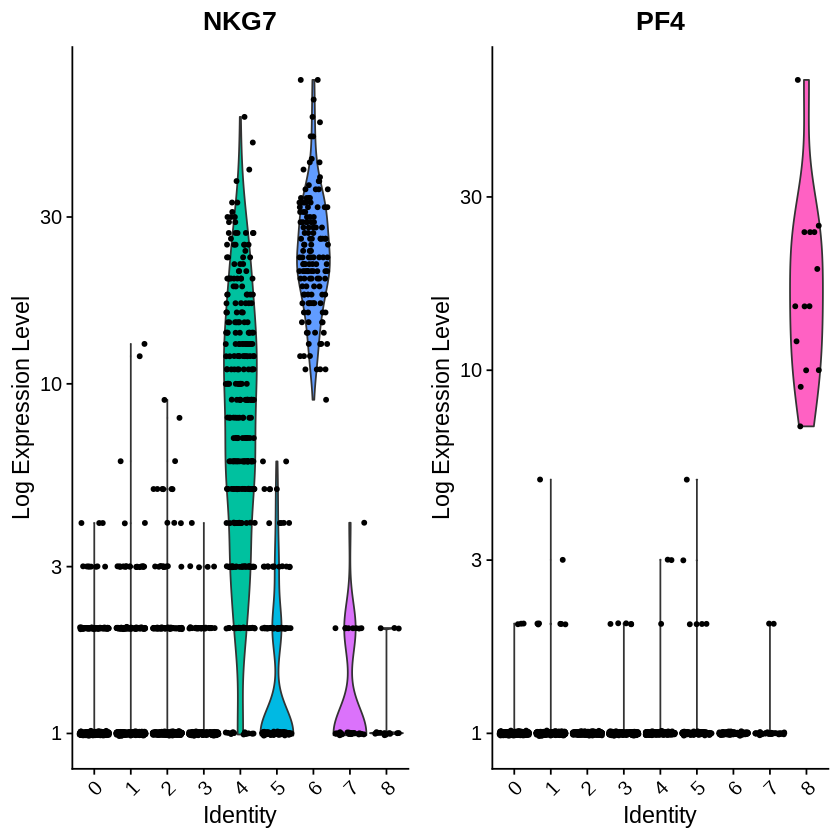

In [31]:
# raw counts (正規化前UMI数)
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

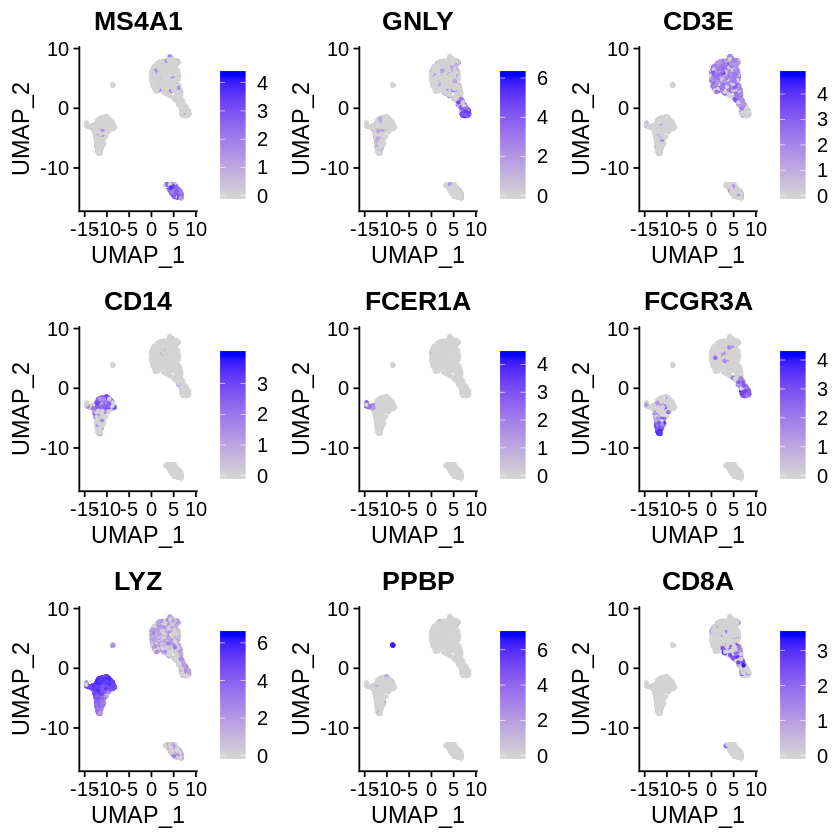

In [32]:
# UMAP (tSNE) プロット上で発現量を可視化
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"))

Warning message in DoHeatmap(pbmc, features = top10$gene):
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: CD8A, VPREB3, TRAT1, PIK3IP1, PRKCQ-AS1, NOSIP, LEF1, CD3E, CD3D, CCR7, RPS3A, LDHB”

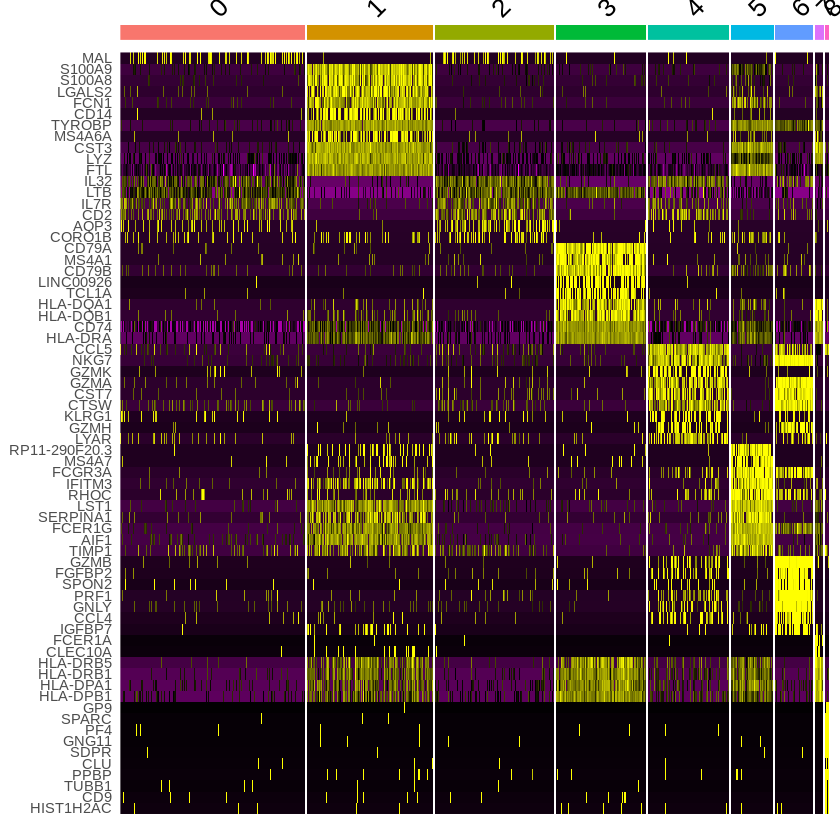

In [33]:
# Heatmap形式での可視化
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

## クラスタのアノテーション (手作業でアノテートする場合)

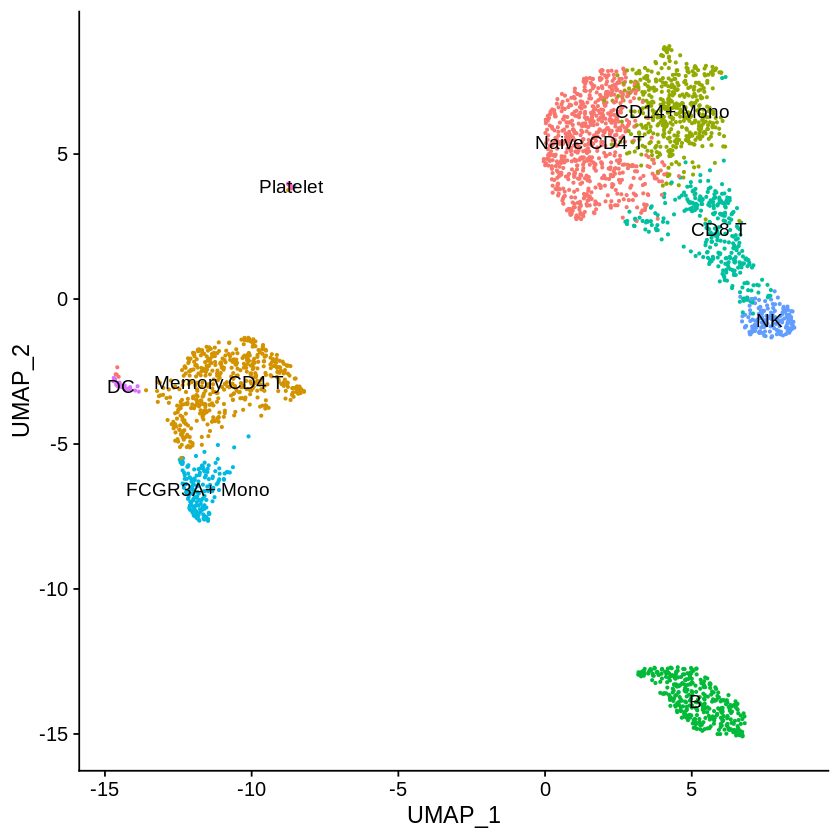

In [72]:
new.cluster.ids <- c("Naive CD4 T", "Memory CD4 T", "CD14+ Mono", "B", "CD8 T", "FCGR3A+ Mono", "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [73]:
# データ保存
saveRDS(pbmc, file = "pbmc3k_final.rds")